# 청년AI/BigData아카데미 22기
## ResNet

## Exercise 3-1. Implement Residual Block

In [38]:
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(0.5, 0.5)])

train_data = torchvision.datasets.MNIST("./data", train=True, download=True, transform=transform)
test_data = torchvision.datasets.MNIST("./data", train=False, download=True, transform=transform)

print(len(train_data))
print(len(test_data))

60000
10000


In [49]:
from torch.utils.data import DataLoader

batch_size = 8

trainloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
testloader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

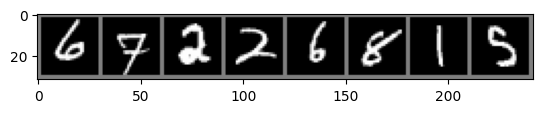

    6     7     2     2     6     8     1     5


In [50]:
# display some images

import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
    
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

classes = ('0', '1', '2', '3', '4', 
           '5', '6', '7', '8', '9')

# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(8)))

In [51]:
import torch
import torch.nn as nn

In [52]:
class BasicBlock(nn.Module):
    ### implement this
    def __init__(self, in_channels, out_channels):
        super().__init__()
        
        ##forward ## conv, bn, relu, conv, bn , addition , relu
        self.residual_function = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size = 3, padding = 1, stride = 1, bias = False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size = 3, padding = 1, stride = 1, bias = False),
            nn.BatchNorm2d(out_channels)
        )
        
        self.shortcut = nn.Sequential()
        
        self.relu = nn.ReLU()
        
        if in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size = 1, bias = False),
                nn.BatchNorm2d(out_channels)
            )
        
    def forward(self, x):
        ## input channel: 64, out channel: 128
        # residual_function -> 128 channel, shortcut 64
        x = self.residual_function(x) + self.shortcut(x)
        x = self.relu(x)
        return x

## Exercise 3-2. Implement ResNet-18

In [55]:
class ResNet18(nn.Module):
    def __init__(self, block, num_classes=10):
        super(ResNet18, self).__init__()
        ### implement this
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size = 7, stride = 2, padding = 3, bias = False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        )
        
        self.conv2_1 = block(64, 64)
        self.conv2_2 = block(64, 64)
        
        self.conv3_1 = block(64, 128)
        self.conv3_2 = block(128, 128)
        
        self.conv4_1 = block(128, 256)
        self.conv4_2 = block(256, 256)
        
        self.conv5_1 = block(256, 512)
        self.conv5_2 = block(512, 512)
        
        ## average pooling
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1)) # h*w ->1*1
        self.fc = nn.Linear(512, num_classes)
        
    def forward(self,x):
        # x:[batch, 3, 32, 32]
        ### implement this
        
        x = self.conv1(x)
        
        x = self.conv2_1(x)
        x = self.conv2_2(x)
        
        x = self.conv3_1(x)
        x = self.conv3_2(x)

        x = self.conv4_1(x)
        x = self.conv4_2(x)

        x = self.conv5_1(x)
        x = self.conv5_2(x) # [batch, 512, h, w]
        
        x = self.avg_pool(x) # [batch, 512, 1, 1]
        
        x = x.view(x.size(0), -1) # [batch, 512]
        
        x = self.fc(x) #[batch, 10]

        return x

In [56]:
!pip install torchsummary
from torchsummary import summary

net = ResNet18(BasicBlock)
summary(net, batch_size=-1, input_size=(1, 32, 32), device='cpu')
net = net.cuda()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           3,136
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]          36,864
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
       BasicBlock-11             [-1, 64, 8, 8]               0
           Conv2d-12             [-1, 64, 8, 8]          36,864
      BatchNorm2d-13             [-1, 64, 8, 8]             128
             ReLU-14             [-1, 6

### Define a Loss function and optimizer
* Use Classification Cross-Entropy loss
* Use Adam with learning rate 0.0001 

In [57]:
import torch.optim as optim

# define a loss and optimizer
criterion = nn.CrossEntropyLoss() #CrossEntropyLoss에 softmax까지 구현되어있기 때문에 모델에 softmax를 선언하지 않아도 됨. 
optimizer = optim.Adam(net.parameters(), lr=0.0001)

In [58]:
def train(net, optimizer, epoch):
    net.train()
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        images, labels = data
        images, labels = images.cuda(), labels.cuda()

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        
        if i % 50 == 49:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 50))
            running_loss = 0.0
            
def test(net):
    correct = 0.
    total = 0.
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    
    net.eval()
    for data in testloader:
        images, labels = data
        images, labels = images.cuda(), labels.cuda()
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum()
        for idx in range(10): 
            label_idx = (labels == idx)
            if label_idx.sum().item() == 0: 
                continue
            class_correct[idx] += labels[label_idx].eq(torch.argmax(outputs[label_idx], 1)).sum().item()
            class_total[idx] += labels[label_idx].size(0)

    print('Accuracy of the network on the test images: %d %%' % (100 * correct / total))
    for i in range(10):
        print('Accuracy of %5s : %2d %%' % (
            classes[i], 100 * class_correct[i] / class_total[i]))

In [59]:
for epoch in range(0, 5):
    train(net, optimizer, epoch)
test(net)

[1,    50] loss: 1.283
[1,   100] loss: 0.647
[1,   150] loss: 0.497
[1,   200] loss: 0.474
[1,   250] loss: 0.414
[1,   300] loss: 0.373
[1,   350] loss: 0.334
[1,   400] loss: 0.266
[1,   450] loss: 0.313
[1,   500] loss: 0.270
[1,   550] loss: 0.259
[1,   600] loss: 0.286
[1,   650] loss: 0.229
[1,   700] loss: 0.198
[1,   750] loss: 0.168
[1,   800] loss: 0.157
[1,   850] loss: 0.358
[1,   900] loss: 0.226
[1,   950] loss: 0.148
[1,  1000] loss: 0.241
[1,  1050] loss: 0.159
[1,  1100] loss: 0.298
[1,  1150] loss: 0.279
[1,  1200] loss: 0.167
[1,  1250] loss: 0.144
[1,  1300] loss: 0.158
[1,  1350] loss: 0.234
[1,  1400] loss: 0.135
[1,  1450] loss: 0.191
[1,  1500] loss: 0.101
[1,  1550] loss: 0.221
[1,  1600] loss: 0.163
[1,  1650] loss: 0.105
[1,  1700] loss: 0.119
[1,  1750] loss: 0.162
[1,  1800] loss: 0.173
[1,  1850] loss: 0.081
[1,  1900] loss: 0.102
[1,  1950] loss: 0.162
[1,  2000] loss: 0.191
[1,  2050] loss: 0.125
[1,  2100] loss: 0.240
[1,  2150] loss: 0.097
[1,  2200] 

KeyboardInterrupt: 

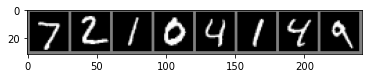

GrondTruth:      7     2     1     0     4     1     4     9


In [ ]:
dataiter = iter(testloader)
images, labels = dataiter.next()
#print images
imshow(torchvision.utils.make_grid(images))
print('GrondTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))


In [ ]:
images = images.cuda()
outputs = net(images)

_, predicted = torch.max(outputs, 1)

print('Predicted(net_plain): ', ' '.join('%5s' % classes[predicted[j]] for j in range(batch_size))) 


Predicted(net_plain):      7     2     1     0     4     1     4     9


In [ ]:
test(net)

Accuracy of the network on the test images: 99 %
Accuracy of     0 : 99 %
Accuracy of     1 : 99 %
Accuracy of     2 : 99 %
Accuracy of     3 : 99 %
Accuracy of     4 : 99 %
Accuracy of     5 : 98 %
Accuracy of     6 : 98 %
Accuracy of     7 : 99 %
Accuracy of     8 : 98 %
Accuracy of     9 : 98 %
